In [7]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric import utils
import torch_geometric as pyg
from tqdm.auto import tqdm
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
from pyvis.network import Network
import matplotlib.pyplot as plt
from itertools import chain
from sklearn.metrics import accuracy_score

### creating a sample set for model

In [8]:
# using 10000 nodes
graph = torch.load('../AmazonNodeGraph.pt')
mask = np.zeros(graph.x.shape[0])
mask[:10000] = 1
mask = torch.tensor(mask == 1)
g = Data(x=graph.x[mask], edge_index=utils.subgraph(mask, graph.edge_index)[0])
torch.save(g, 'model_graph.pt')

In [9]:
# Initializing the PyVis network with custom dimensions and styling
net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")

# Iterating through the edges of the graph to add nodes and edges to the PyVis network
for edge in g.edge_index.T:
    source_node = edge[0].item()
    target_node = edge[1].item()
    
    # Adding source and target nodes to the network
    net.add_node(source_node)
    net.add_node(target_node)
    
    # Adding an edge between source and target nodes with a specified value
    net.add_edge(source_node, target_node, value=0.1)

# Saving the PyVis visualization to an HTML file
net.save_graph('model_graph.html')


### splitting the sample dataset into the training and validation set

In [10]:
# Loading the graph data from a saved file
graph = torch.load('model_graph.pt')

# Initializing the transformation method with specified validation and test data proportions
transform = RandomLinkSplit(num_val=0.1, num_test=0, split_labels=True)

# Applying the transformation to split the graph nodes into train, validation, and test sets
train_data, val_data, test_data = transform(graph)

# Saving the train, validation, and test data into separate files
torch.save(train_data, 'train.pt')
torch.save(val_data, 'validate.pt')


### Define the GNN model and link predictor

In [11]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(GNN, self).__init__()

        # Choosing the GraphSAGE convolutional model
        conv_model = pyg.nn.SAGEConv

        # Initializing list to hold the convolutional layers
        self.convs = nn.ModuleList()

        # Adding the first GraphSAGE convolutional layer
        self.convs.append(conv_model(input_dim, hidden_dim))

        # Storing dropout probability and number of layers
        self.dropout = dropout
        self.num_layers = num_layers

        # Creating additional GraphSAGE convolutions based on the number of layers
        assert (self.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(self.num_layers - 1):
            self.convs.append(conv_model(hidden_dim, hidden_dim))

        # Defining post-message-passing processing layers
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(self.dropout),
            nn.Linear(hidden_dim, output_dim))

    def forward(self, x, edge_index):
        # Printing input shape for debugging purposes
        print(f"Input Shape: {x.shape}")

        # Looping through the convolutional layers
        for i in range(self.num_layers):
            # Applying the convolutional layer
            x = self.convs[i](x, edge_index)
            # Applying ReLU activation function
            x = F.relu(x)
            # Applying dropout regularization
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Applying post-message-passing processing layers
        x = self.post_mp(x)

        # Printing output shape for debugging purposes
        print(f"Output Shape: {x.shape}")

        return x

In [12]:
class LinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout):
        super(LinkPredictor, self).__init__()

        # Creating linear layers
        self.lins = nn.ModuleList()
        self.lins.append(nn.Linear(in_channels, hidden_channels))

        # Adding hidden layers based on the number of layers
        for _ in range(num_layers - 2):
            self.lins.append(nn.Linear(hidden_channels, hidden_channels))

        # Adding the output layer
        self.lins.append(nn.Linear(hidden_channels, out_channels))

        # Storing dropout probability
        self.dropout = dropout

    def reset_parameters(self):
        # Resetting parameters of each linear layer
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        # Element-wise multiplication of input tensors
        x = x_i * x_j

        # Passing through each linear layer followed by ReLU activation and dropout
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        # Passing through the output layer with sigmoid activation
        x = self.lins[-1](x)
        return torch.sigmoid(x)

### Train the model and output training loss

In [13]:
# Loading the training data from a saved file
train_graph = torch.load('train.pt')

# Setting the device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Setting weight decay for optimization
optim_wd = 0

# Setting the dimensionality of hidden layers
hidden_dim = 1024

# Setting dropout probability
dropout = 0.1

# Setting the number of layers in the model
num_layers = 2

# Setting the learning rate for optimization
lr = 1e-5

# Setting the dimensionality of node embeddings
node_emb_dim = 1

# Setting the batch size for training
batch_size = 1024

# Moving the training graph data to the specified device (GPU or CPU)
train_graph = train_graph.to(device)


In [14]:

# Creating the graph neural network model
# Inputs: node embedding dimension, hidden layer dimension, number of layers, dropout probability
model = GNN(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout).to(device)

# Creating the link predictor model
# Inputs: input channel dimension, hidden channel dimension, output channel dimension, number of layers, dropout probability
link_predictor = LinkPredictor(hidden_dim, hidden_dim, 1, num_layers + 1, dropout).to(device)


In [15]:
# Defining the training function
def train(model, link_predictor, x, edge_index, pos_train_edge, batch_size, optimizer):
    # Setting the models to train mode
    model.train()
    link_predictor.train()

    # List to store training losses
    train_losses = []

    # Iterating through batches of positive training edges
    for edge_id in tqdm(pyg.loader.DataLoader(range(pos_train_edge.shape[0]), batch_size, shuffle=True), leave=True):
        # Resetting optimizer gradients
        optimizer.zero_grad()

        # Running message passing on the initial node features to obtain updated embeddings
        node_emb = model(x, edge_index)

        # Extracting positive edges
        pos_edge = pos_train_edge[edge_id].T

        # Predicting link probability for positive edges
        pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])

        # Sampling negative edges
        neg_edge = negative_sampling(edge_index, num_nodes=x.shape[0], num_neg_samples=edge_id.shape[0], method='dense')

        # Predicting link probability for negative edges
        neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])

        # Computing negative log likelihood loss on positive and negative edges
        loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()

        # Backpropagating and updating parameters
        loss.backward()
        optimizer.step()

        # Appending current loss to list of training losses
        train_losses.append(loss.item())

    return train_losses


In [16]:
# Defining the optimizer
optimizer = torch.optim.Adam(
    # Combining parameters from both the GNN model and the link predictor model
    list(model.parameters()) + list(link_predictor.parameters()),
    lr=lr,  # Setting the learning rate
    weight_decay=optim_wd  # Setting weight decay for regularization
)


In [17]:
# Training loop
num_epochs = 30
train_losses = []

# Iterate over epochs
for epoch in range(num_epochs):
    # Train the model and get epoch loss
    epoch_loss = train(
        model,
        link_predictor,
        torch.tensor(train_graph.x).to(torch.float32).to(device),
        train_graph.edge_index,
        train_graph.pos_edge_label_index.T,
        batch_size,
        optimizer
    )
    # Store epoch loss
    train_losses.extend(epoch_loss)

    # Print progress every 10 epochs
    if epoch % 10 == 0:
        # Compute node embeddings
        node_emb = model(torch.tensor(train_graph.x).to(torch.float32).to(device), train_graph.edge_index)
        # Get positive edges
        pos_edge = train_graph.pos_edge_label_index.T
        # Predict positive edges
        pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])
        # Print epoch information
        print(f"Epoch {epoch}, Node embeddings shape: {node_emb.shape}, Positive predictions shape: {pos_pred.shape}")


C:\Users\reshm\AppData\Local\Temp\ipykernel_28888\3154946830.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(train_graph.x).to(torch.float32).to(device),
  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:27,  4.11s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:08<02:25,  4.15s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:12<02:15,  3.98s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:15<02:07,  3.87s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:19<02:01,  3.79s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:23<01:55,  3.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:26<01:52,  3.75s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:30<01:48,  3.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:34<01:45,  3.76s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:38<01:41,  3.75s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:41<01:37,  3.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:45<01:33,  3.75s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [00:49<01:29,  3.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [00:52<01:25,  3.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [00:56<01:21,  3.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:00<01:17,  3.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:04<01:14,  3.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:12<01:36,  5.09s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:16<01:24,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:19<01:15,  4.43s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:23<01:07,  4.23s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:27<01:01,  4.11s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:31<00:56,  4.01s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:35<00:51,  3.95s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:38<00:46,  3.88s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [01:42<00:42,  3.85s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [01:46<00:38,  3.82s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [01:50<00:33,  3.77s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [01:53<00:30,  3.77s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [01:57<00:26,  3.77s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:01<00:22,  3.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:04<00:18,  3.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:08<00:15,  3.75s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:12<00:11,  3.76s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:16<00:07,  3.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:19<00:03,  3.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


100%|██████████| 37/37 [02:23<00:00,  3.88s/it]
C:\Users\reshm\AppData\Local\Temp\ipykernel_28888\3154946830.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_emb = model(torch.tensor(train_graph.x).to(torch.float32).to(device), train_graph.edge_index)


Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Epoch 0, Node embeddings shape: torch.Size([10000, 1024]), Positive predictions shape: torch.Size([2, 1])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:03<02:13,  3.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:07<02:07,  3.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:10<02:03,  3.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:14<02:01,  3.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:18<01:56,  3.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:21<01:53,  3.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:25<01:49,  3.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:29<01:45,  3.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:33<01:43,  3.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:36<01:38,  3.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:40<01:34,  3.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:43<01:31,  3.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [00:47<01:28,  3.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [00:51<01:24,  3.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [00:55<01:21,  3.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [00:58<01:17,  3.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:02<01:13,  3.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:05<01:09,  3.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:09<01:05,  3.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:13<01:01,  3.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:16<00:58,  3.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:20<00:54,  3.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:24<00:51,  3.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:28<00:48,  3.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:31<00:44,  3.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [01:35<00:40,  3.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [01:39<00:37,  3.75s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [01:43<00:33,  3.75s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [01:46<00:30,  3.77s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [01:50<00:26,  3.76s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [01:54<00:22,  3.79s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [01:58<00:18,  3.78s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:02<00:15,  3.79s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:05<00:11,  3.77s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:09<00:07,  3.79s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:13<00:03,  3.77s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:03<02:12,  3.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:07<02:12,  3.78s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:11<02:09,  3.80s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:15<02:07,  3.86s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:19<02:05,  3.93s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:23<02:02,  3.95s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:27<01:58,  3.95s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:31<01:54,  3.95s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:35<01:49,  3.91s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:39<01:45,  3.92s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:42<01:41,  3.90s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:46<01:37,  3.88s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [00:50<01:32,  3.86s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [00:54<01:28,  3.86s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [00:58<01:24,  3.84s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:01<01:20,  3.83s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:05<01:16,  3.82s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:09<01:12,  3.84s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:13<01:08,  3.83s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:17<01:05,  3.83s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:21<01:00,  3.81s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:24<00:57,  3.82s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:28<00:53,  3.82s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:32<00:49,  3.84s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:36<00:46,  3.84s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [01:40<00:42,  3.84s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [01:44<00:38,  3.82s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [01:47<00:34,  3.82s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [01:51<00:30,  3.78s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [01:55<00:26,  3.80s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [01:59<00:22,  3.80s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:03<00:19,  3.81s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:06<00:15,  3.81s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:10<00:11,  3.82s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:14<00:07,  3.82s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:18<00:03,  3.81s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:03<02:18,  3.86s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:07<02:13,  3.81s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:11<02:10,  3.84s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:15<02:06,  3.84s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:19<02:01,  3.81s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:22<01:57,  3.78s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:26<01:53,  3.79s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:30<01:50,  3.79s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:34<01:46,  3.80s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:37<01:42,  3.78s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:41<01:38,  3.80s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:45<01:36,  3.85s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [00:49<01:33,  3.90s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [00:53<01:29,  3.90s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [00:57<01:25,  3.89s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:01<01:21,  3.89s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:05<01:17,  3.89s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:09<01:14,  3.90s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:13<01:10,  3.91s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:17<01:05,  3.88s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:21<01:02,  3.92s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:24<00:58,  3.87s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:28<00:54,  3.88s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:32<00:49,  3.84s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:36<00:46,  3.86s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [01:40<00:42,  3.85s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [01:44<00:38,  3.85s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [01:47<00:34,  3.84s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [01:51<00:31,  3.88s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [01:55<00:27,  3.87s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [01:59<00:23,  3.89s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:03<00:19,  3.89s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:07<00:15,  3.90s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:11<00:11,  3.85s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:15<00:07,  3.86s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:18<00:03,  3.86s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:03<02:17,  3.81s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:07<02:15,  3.86s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:11<02:10,  3.85s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:15<02:07,  3.86s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:19<02:02,  3.83s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:22<01:57,  3.78s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:26<01:53,  3.80s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:30<01:50,  3.80s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:34<01:45,  3.79s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:38<01:43,  3.82s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:41<01:39,  3.82s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:45<01:35,  3.82s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [4:07:29<29:54:49, 4487.08s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [6:17:47<35:05:47, 5493.37s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [6:17:53<23:27:46, 3839.37s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [6:17:59<15:39:53, 2685.42s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [6:18:05<10:26:32, 1879.62s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [6:18:13<6:57:08, 1317.28s/it] 

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [6:18:18<4:36:56, 923.14s/it] 

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [6:18:25<3:03:38, 648.16s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [6:18:30<2:01:23, 455.20s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [6:18:35<1:19:58, 319.91s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [6:18:39<52:31, 225.14s/it]  

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [6:18:44<34:26, 158.96s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [6:18:48<22:30, 112.51s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [6:18:52<14:39, 79.99s/it] 

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [6:18:57<09:34, 57.43s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [6:19:01<06:12, 41.42s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [6:19:04<04:00, 30.07s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [6:19:08<02:35, 22.27s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [6:19:13<01:41, 16.98s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [6:19:17<01:05, 13.07s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [6:19:21<00:42, 10.52s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [6:19:26<00:26,  8.83s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [6:19:31<00:15,  7.53s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [6:19:36<00:06,  6.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:58,  4.96s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:09<02:50,  4.86s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:14<02:43,  4.82s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:19<02:36,  4.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:23<02:30,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:28<02:28,  4.79s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:33<02:22,  4.76s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:38<02:18,  4.76s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:42<02:11,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:47<02:06,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:52<02:00,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:56<01:56,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [01:01<01:52,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:06<01:47,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:10<01:43,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:15<01:38,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:20<01:33,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:24<01:29,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:29<01:24,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:34<01:18,  4.62s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:38<01:14,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:43<01:09,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:48<01:05,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:52<01:00,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:57<00:56,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [02:02<00:51,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:07<00:47,  4.76s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:11<00:43,  4.78s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:16<00:37,  4.75s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:21<00:32,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:25<00:28,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:30<00:23,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:35<00:18,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:39<00:14,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:44<00:09,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:49<00:04,  4.78s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:05<03:04,  5.14s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:09<02:53,  4.96s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:14<02:47,  4.94s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:19<02:38,  4.81s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:24<02:32,  4.76s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:28<02:27,  4.76s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:33<02:25,  4.84s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:38<02:21,  4.88s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:43<02:14,  4.80s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:48<02:09,  4.80s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:52<02:03,  4.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:57<01:57,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [01:02<01:52,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:07<01:50,  4.80s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:11<01:44,  4.77s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:17<01:41,  4.85s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:21<01:34,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:26<01:29,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:30<01:25,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:35<01:20,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:39<01:13,  4.56s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:43<01:05,  4.37s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:48<01:03,  4.56s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:53<00:58,  4.48s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:57<00:54,  4.51s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [02:01<00:48,  4.39s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:05<00:42,  4.24s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:09<00:37,  4.19s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:13<00:32,  4.11s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:18<00:29,  4.28s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:22<00:26,  4.37s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:26<00:21,  4.24s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:30<00:16,  4.16s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:34<00:12,  4.13s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:38<00:08,  4.08s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:42<00:04,  4.05s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:03<02:14,  3.75s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:08<02:27,  4.22s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:12<02:19,  4.09s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:16<02:18,  4.19s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:21<02:19,  4.36s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:25<02:14,  4.34s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:29<02:06,  4.20s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:33<01:58,  4.09s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:37<01:53,  4.05s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:41<01:48,  4.03s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:45<01:45,  4.05s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:49<01:39,  3.97s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [00:52<01:34,  3.93s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [00:57<01:31,  3.99s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:01<01:29,  4.06s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:05<01:26,  4.11s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:09<01:22,  4.12s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:13<01:19,  4.17s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:18<01:14,  4.13s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:21<01:09,  4.08s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:26<01:04,  4.06s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:29<00:59,  3.95s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:33<00:54,  3.91s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:38<00:53,  4.12s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:42<00:50,  4.22s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [01:46<00:45,  4.16s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [01:50<00:41,  4.16s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [01:54<00:37,  4.12s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [01:58<00:32,  4.09s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:02<00:27,  3.98s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:06<00:23,  3.95s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:10<00:20,  4.04s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:14<00:16,  4.06s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:18<00:12,  4.07s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:22<00:07,  3.96s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:26<00:03,  3.97s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:03<02:22,  3.97s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:07<02:13,  3.83s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:11<02:11,  3.88s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:15<02:13,  4.04s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:20<02:16,  4.27s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:24<02:12,  4.27s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:28<02:04,  4.14s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:32<02:00,  4.16s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:37<01:56,  4.17s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:41<01:53,  4.20s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:45<01:49,  4.23s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:50<01:46,  4.25s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [00:53<01:39,  4.14s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [00:57<01:32,  4.03s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:01<01:28,  4.02s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:05<01:24,  4.04s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:09<01:21,  4.05s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:14<01:18,  4.12s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:18<01:12,  4.05s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:22<01:10,  4.13s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:26<01:07,  4.24s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:31<01:05,  4.34s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:36<01:02,  4.45s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:40<00:58,  4.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:45<00:54,  4.52s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [01:49<00:47,  4.34s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [01:52<00:41,  4.17s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [01:56<00:36,  4.05s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:00<00:32,  4.02s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:04<00:28,  4.02s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:08<00:23,  3.98s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:12<00:20,  4.05s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:17<00:16,  4.18s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:22<00:13,  4.51s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:27<00:09,  4.52s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:31<00:04,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:03<02:19,  3.88s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:07<02:18,  3.96s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:12<02:17,  4.04s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:16<02:13,  4.05s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:20<02:12,  4.13s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:25<02:14,  4.35s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:29<02:14,  4.48s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:34<02:11,  4.53s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:39<02:11,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:43<02:00,  4.48s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:47<01:51,  4.30s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:51<01:46,  4.24s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [00:56<01:45,  4.40s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:01<01:43,  4.50s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:05<01:39,  4.51s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:10<01:34,  4.48s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:14<01:29,  4.50s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:19<01:25,  4.50s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:23<01:21,  4.55s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:28<01:18,  4.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:33<01:14,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:37<01:08,  4.55s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:42<01:04,  4.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:46<00:59,  4.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:51<00:56,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [01:56<00:51,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:01<00:46,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:05<00:41,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:10<00:36,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:14<00:32,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:19<00:27,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:24<00:23,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:28<00:18,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:33<00:13,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:38<00:09,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:42<00:04,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:53,  4.83s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:09<02:50,  4.86s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:14<02:40,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:19<02:40,  4.87s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:24<02:35,  4.84s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:29<02:31,  4.90s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:33<02:26,  4.87s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:38<02:21,  4.88s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:43<02:17,  4.92s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:48<02:10,  4.84s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:53<02:05,  4.83s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:58<02:00,  4.81s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [01:02<01:53,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:07<01:48,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:12<01:43,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:16<01:38,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:21<01:34,  4.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:26<01:30,  4.76s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:31<01:25,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:35<01:20,  4.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:40<01:16,  4.76s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:45<01:10,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:50<01:07,  4.82s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:55<01:02,  4.83s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:59<00:57,  4.82s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [02:04<00:52,  4.81s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:09<00:47,  4.75s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:14<00:42,  4.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:18<00:37,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:23<00:32,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:27<00:27,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:32<00:23,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:37<00:18,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:42<00:14,  4.75s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:46<00:09,  4.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:51<00:04,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


100%|██████████| 37/37 [02:55<00:00,  4.75s/it]


Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Epoch 10, Node embeddings shape: torch.Size([10000, 1024]), Positive predictions shape: torch.Size([2, 1])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:52,  4.79s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:09<02:42,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:13<02:37,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:18<02:34,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:23<02:28,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:27<02:23,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:32<02:18,  4.62s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:37<02:14,  4.62s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:41<02:10,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:46<02:06,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:51<01:59,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:55<01:55,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [01:00<01:50,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:04<01:45,  4.57s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:09<01:41,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:14<01:36,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:18<01:32,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:23<01:29,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:28<01:25,  4.75s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:33<01:21,  4.80s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:38<01:16,  4.76s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:42<01:11,  4.77s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:47<01:06,  4.75s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:52<01:01,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:56<00:56,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [02:01<00:51,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:06<00:46,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:11<00:42,  4.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:16<00:38,  4.80s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:20<00:33,  4.82s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:25<00:29,  4.85s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:30<00:24,  4.83s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:35<00:18,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:39<00:14,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:44<00:09,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:49<00:04,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:48,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:09<02:41,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:13<02:38,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:18<02:33,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:23<02:28,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:28<02:25,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:32<02:20,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:37<02:14,  4.62s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:42<02:11,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:47<02:10,  4.85s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:52<02:06,  4.86s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:56<01:59,  4.80s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [01:01<01:53,  4.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:05<01:48,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:10<01:44,  4.77s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:16<01:44,  4.96s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:20<01:37,  4.87s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:25<01:32,  4.89s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:30<01:27,  4.89s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:35<01:22,  4.85s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:40<01:18,  4.90s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:45<01:13,  4.90s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:50<01:08,  4.88s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:55<01:02,  4.83s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:59<00:57,  4.82s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [02:04<00:52,  4.77s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:09<00:47,  4.78s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:14<00:42,  4.78s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:18<00:37,  4.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:23<00:32,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:27<00:28,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:32<00:23,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:37<00:18,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:42<00:14,  4.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:46<00:09,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:51<00:04,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:45,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:09<02:41,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:13<02:38,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:18<02:32,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:23<02:28,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:27<02:23,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:32<02:19,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:37<02:16,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:41<02:10,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:46<02:07,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:51<02:01,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:56<01:59,  4.79s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [01:00<01:53,  4.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:05<01:48,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:10<01:43,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:15<01:39,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:19<01:33,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:24<01:28,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:28<01:23,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:33<01:18,  4.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:38<01:14,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:42<01:10,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:47<01:05,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:52<01:00,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:56<00:55,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [02:01<00:50,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:05<00:46,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:10<00:41,  4.62s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:15<00:36,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:19<00:32,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:24<00:27,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:29<00:23,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:33<00:18,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:39<00:14,  4.98s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:44<00:09,  4.89s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:49<00:04,  4.90s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:55,  4.87s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:09<02:47,  4.80s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:14<02:40,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:18<02:35,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:23<02:29,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:28<02:24,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:32<02:20,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:37<02:16,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:42<02:11,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:46<02:06,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:51<02:00,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:56<01:56,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [01:00<01:50,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:05<01:45,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:09<01:41,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:14<01:36,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:19<01:34,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:24<01:30,  4.78s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:29<01:26,  4.83s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:33<01:19,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:37<01:12,  4.50s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:42<01:07,  4.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:46<01:03,  4.51s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:51<00:58,  4.51s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:55<00:53,  4.45s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [01:59<00:48,  4.37s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:04<00:43,  4.37s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:08<00:40,  4.47s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:13<00:36,  4.51s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:18<00:31,  4.51s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:22<00:27,  4.62s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:27<00:23,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:32<00:18,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:36<00:13,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:41<00:09,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:45<00:04,  4.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:45,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:09<02:42,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:13<02:36,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:18<02:31,  4.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:23<02:28,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:27<02:22,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:32<02:18,  4.62s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:36<02:13,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:41<02:08,  4.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:46<02:03,  4.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:50<01:58,  4.57s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:55<01:54,  4.56s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [00:59<01:49,  4.57s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:04<01:45,  4.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:08<01:40,  4.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:13<01:36,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:18<01:32,  4.62s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:22<01:27,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:27<01:23,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:32<01:19,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:36<01:14,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:41<01:08,  4.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:45<01:04,  4.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:50<00:59,  4.57s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:54<00:54,  4.54s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [01:59<00:50,  4.56s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:04<00:45,  4.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:08<00:41,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:13<00:36,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:18<00:32,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:22<00:27,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:27<00:22,  4.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:31<00:18,  4.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:36<00:13,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:41<00:09,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:45<00:04,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:49,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:09<02:43,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:14<02:39,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:18<02:34,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:23<02:29,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:28<02:28,  4.79s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:32<02:20,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:37<02:16,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:42<02:10,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:47<02:10,  4.85s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:52<02:05,  4.83s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:56<01:59,  4.79s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [01:01<01:53,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:06<01:48,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:10<01:43,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:15<01:38,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:20<01:33,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:24<01:29,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:29<01:25,  4.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:34<01:20,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:39<01:15,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:43<01:09,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:48<01:05,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:52<01:00,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:57<00:55,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [02:02<00:50,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:06<00:46,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:11<00:43,  4.78s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:16<00:38,  4.75s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:21<00:33,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:25<00:28,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:30<00:23,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:35<00:18,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:39<00:13,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:44<00:09,  4.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:48<00:04,  4.62s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:54,  4.85s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:09<02:44,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:14<02:40,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:18<02:34,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:23<02:30,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:28<02:26,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:33<02:21,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:37<02:15,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:42<02:10,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:46<02:05,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:51<02:02,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:56<01:56,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [01:00<01:51,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:05<01:46,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:10<01:42,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:14<01:37,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:19<01:32,  4.62s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:24<01:28,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:28<01:23,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:33<01:19,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:37<01:14,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:42<01:08,  4.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:47<01:05,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:51<01:00,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:56<00:55,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [02:01<00:50,  4.62s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:05<00:46,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:10<00:42,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:15<00:37,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:20<00:33,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:25<00:28,  4.83s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:29<00:23,  4.79s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:34<00:18,  4.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:39<00:14,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:43<00:09,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:48<00:04,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:51,  4.77s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:09<02:48,  4.82s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:14<02:40,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:18<02:33,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:23<02:27,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:28<02:24,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:32<02:22,  4.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:37<02:16,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:42<02:10,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:46<02:05,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:51<01:59,  4.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:55<01:55,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [01:00<01:50,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:05<01:45,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:09<01:41,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:14<01:35,  4.56s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:18<01:30,  4.55s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:23<01:26,  4.53s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:27<01:21,  4.53s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:32<01:16,  4.51s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:36<01:11,  4.48s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:41<01:07,  4.51s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:46<01:05,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:50<01:00,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:55<00:55,  4.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [01:59<00:50,  4.56s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:04<00:45,  4.51s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:08<00:40,  4.54s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:13<00:36,  4.55s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:18<00:32,  4.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:22<00:27,  4.52s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:26<00:22,  4.50s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:31<00:17,  4.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:35<00:13,  4.53s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:40<00:09,  4.52s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:44<00:04,  4.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:37,  4.38s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:08<02:34,  4.42s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:13<02:32,  4.48s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:17<02:29,  4.52s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:22<02:24,  4.52s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:26<02:18,  4.48s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:31<02:14,  4.47s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:35<02:09,  4.48s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:40<02:05,  4.46s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:44<02:02,  4.53s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:49<01:57,  4.53s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:54<01:53,  4.54s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [00:58<01:49,  4.55s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:03<01:44,  4.53s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:07<01:41,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:12<01:39,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:17<01:32,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:21<01:27,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:26<01:21,  4.56s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:30<01:17,  4.55s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:35<01:12,  4.50s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:39<01:07,  4.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:44<01:02,  4.48s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:48<00:58,  4.48s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:53<00:53,  4.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [01:57<00:49,  4.50s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:02<00:45,  4.52s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:06<00:40,  4.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:11<00:36,  4.53s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:15<00:31,  4.54s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:20<00:26,  4.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:24<00:22,  4.51s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:29<00:17,  4.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:33<00:13,  4.47s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:38<00:08,  4.47s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:42<00:04,  4.44s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:39,  4.44s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:08<02:36,  4.46s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:13<02:33,  4.50s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:18<02:28,  4.51s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:22<02:25,  4.53s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:27<02:21,  4.57s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:31<02:16,  4.56s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:36<02:12,  4.57s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:40<02:07,  4.57s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:45<02:04,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:49<01:57,  4.53s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:54<01:53,  4.55s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [00:58<01:48,  4.50s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:03<01:43,  4.50s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:07<01:38,  4.47s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:12<01:33,  4.47s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:16<01:29,  4.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:21<01:25,  4.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:25<01:21,  4.51s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:30<01:16,  4.50s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:34<01:11,  4.48s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:39<01:07,  4.50s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:43<01:02,  4.47s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:48<00:58,  4.47s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:52<00:53,  4.47s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [01:57<00:49,  4.47s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:02<00:45,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:06<00:41,  4.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:11<00:36,  4.56s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:15<00:31,  4.54s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:20<00:27,  4.51s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:24<00:22,  4.50s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:28<00:17,  4.47s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:33<00:13,  4.51s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:37<00:08,  4.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:42<00:04,  4.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


100%|██████████| 37/37 [02:46<00:00,  4.51s/it]


Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])
Epoch 20, Node embeddings shape: torch.Size([10000, 1024]), Positive predictions shape: torch.Size([2, 1])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:41,  4.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:08<02:36,  4.46s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:13<02:32,  4.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:17<02:28,  4.50s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:22<02:24,  4.52s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:27<02:21,  4.57s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:31<02:16,  4.56s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:36<02:11,  4.52s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:40<02:06,  4.52s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:45<02:02,  4.53s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:49<01:57,  4.53s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:54<01:53,  4.55s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [00:58<01:49,  4.56s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:03<01:45,  4.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:08<01:41,  4.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:12<01:36,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:17<01:31,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:21<01:26,  4.57s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:26<01:22,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:31<01:17,  4.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:35<01:12,  4.56s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:40<01:08,  4.56s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:44<01:04,  4.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:49<00:59,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:53<00:54,  4.54s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [01:58<00:49,  4.51s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:02<00:45,  4.54s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:08<00:42,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:12<00:37,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:17<00:32,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:21<00:27,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:26<00:23,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:31<00:18,  4.62s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:35<00:13,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:40<00:09,  4.57s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:44<00:04,  4.54s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:36,  4.36s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:08<02:36,  4.46s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:13<02:32,  4.48s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:17<02:27,  4.48s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:22<02:23,  4.47s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:26<02:18,  4.45s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:31<02:12,  4.43s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:35<02:08,  4.44s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:39<02:03,  4.42s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:44<01:59,  4.42s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:49<01:57,  4.50s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:53<01:53,  4.55s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [00:58<01:48,  4.52s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:02<01:43,  4.52s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:07<01:39,  4.54s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:11<01:34,  4.52s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:16<01:29,  4.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:20<01:26,  4.57s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:25<01:23,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:30<01:19,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:35<01:14,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:39<01:09,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:44<01:04,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:49<01:00,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:53<00:55,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [01:58<00:51,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:03<00:47,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:07<00:41,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:12<00:36,  4.57s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:16<00:31,  4.56s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:21<00:27,  4.53s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:25<00:22,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:30<00:18,  4.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:34<00:13,  4.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:39<00:09,  4.53s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:43<00:04,  4.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:50,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:09<02:42,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:14<02:40,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:18<02:34,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:23<02:30,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:27<02:23,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:32<02:18,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:37<02:12,  4.56s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:41<02:10,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:46<02:05,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:51<02:01,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:55<01:56,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [01:00<01:51,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:05<01:47,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:10<01:43,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:14<01:37,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:19<01:33,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:23<01:28,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:28<01:23,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:33<01:18,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:37<01:15,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:42<01:11,  4.76s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:47<01:06,  4.75s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:52<01:02,  4.79s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:57<00:56,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [02:01<00:51,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:06<00:46,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:10<00:42,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:15<00:37,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:20<00:33,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:25<00:28,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:29<00:23,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:34<00:18,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:39<00:14,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:43<00:09,  4.75s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:48<00:04,  4.76s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:44,  4.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:09<02:42,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:14<02:40,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:18<02:34,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:23<02:29,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:28<02:26,  4.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:32<02:21,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:37<02:18,  4.78s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:42<02:12,  4.75s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:47<02:07,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:51<02:02,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:56<01:58,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [01:01<01:52,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:06<01:48,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:10<01:43,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:15<01:39,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:20<01:34,  4.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:24<01:29,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:29<01:23,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:33<01:18,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:38<01:14,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:43<01:09,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:47<01:05,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:52<01:00,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:57<00:55,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [02:01<00:50,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:06<00:46,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:11<00:41,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:15<00:36,  4.62s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:20<00:32,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:25<00:28,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:29<00:23,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:34<00:18,  4.62s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:39<00:13,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:43<00:09,  4.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:48<00:04,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:47,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:09<02:44,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:14<02:39,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:18<02:34,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:23<02:27,  4.62s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:27<02:23,  4.62s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:32<02:18,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:37<02:13,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:41<02:08,  4.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:46<02:05,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:51<02:01,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:55<01:57,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [01:00<01:52,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:05<01:49,  4.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:10<01:43,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:14<01:39,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:19<01:36,  4.82s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:24<01:31,  4.79s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:29<01:25,  4.76s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:33<01:20,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:38<01:15,  4.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:43<01:10,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:47<01:05,  4.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:52<01:00,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:57<00:56,  4.67s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [02:01<00:51,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:06<00:47,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:11<00:42,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:16<00:38,  4.77s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:20<00:33,  4.76s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:25<00:28,  4.77s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:30<00:23,  4.78s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:35<00:19,  4.75s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:40<00:14,  4.76s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:44<00:09,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:49<00:04,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:44,  4.56s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:09<02:45,  4.73s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:13<02:31,  4.45s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:17<02:26,  4.44s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:22<02:23,  4.48s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:27<02:23,  4.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:33<02:33,  5.10s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:40<02:44,  5.66s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:44<02:25,  5.21s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:48<02:13,  4.95s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:53<02:08,  4.95s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:59<02:05,  5.01s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [01:04<02:04,  5.20s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:09<01:59,  5.18s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:15<01:54,  5.19s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:20<01:53,  5.40s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:26<01:49,  5.46s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:31<01:42,  5.40s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:36<01:34,  5.26s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:41<01:28,  5.20s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:46<01:22,  5.15s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:52<01:19,  5.32s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:58<01:15,  5.41s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [02:03<01:10,  5.44s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [02:10<01:10,  5.85s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [02:16<01:06,  6.00s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:21<00:54,  5.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:25<00:45,  5.11s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:30<00:40,  5.11s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:35<00:35,  5.01s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:41<00:32,  5.35s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:46<00:26,  5.23s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:50<00:19,  4.99s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:55<00:14,  4.81s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:59<00:09,  4.82s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [03:04<00:04,  4.83s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:55,  4.88s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:09<02:40,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:13<02:31,  4.45s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:18<02:30,  4.55s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:22<02:26,  4.57s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:27<02:26,  4.74s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:32<02:20,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:36<02:12,  4.56s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:40<02:04,  4.45s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:45<02:04,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:50<01:59,  4.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:55<01:57,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [00:59<01:50,  4.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [01:04<01:43,  4.52s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:08<01:39,  4.51s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:13<01:35,  4.53s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:18<01:33,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:22<01:29,  4.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:27<01:24,  4.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:32<01:19,  4.68s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:37<01:18,  4.88s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:41<01:09,  4.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:45<01:01,  4.40s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:49<00:55,  4.26s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:53<00:51,  4.31s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [01:58<00:47,  4.33s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [02:02<00:42,  4.29s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [02:07<00:40,  4.47s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:11<00:35,  4.46s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:16<00:32,  4.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:21<00:27,  4.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:25<00:22,  4.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:30<00:18,  4.55s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:35<00:14,  4.69s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:39<00:09,  4.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:43<00:04,  4.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:32,  4.24s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:08<02:24,  4.13s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:12<02:19,  4.10s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:16<02:14,  4.09s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:20<02:11,  4.11s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:24<02:08,  4.15s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:28<02:03,  4.11s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:32<01:59,  4.12s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:37<01:54,  4.09s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:41<01:50,  4.11s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:45<01:46,  4.11s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:49<01:42,  4.12s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [00:53<01:38,  4.12s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [00:57<01:34,  4.12s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:01<01:30,  4.11s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:05<01:25,  4.07s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:09<01:22,  4.13s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:14<01:18,  4.13s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:18<01:14,  4.13s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:22<01:10,  4.12s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:26<01:06,  4.14s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:30<01:02,  4.16s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:34<00:57,  4.14s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:38<00:53,  4.15s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:43<00:49,  4.17s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [01:47<00:46,  4.19s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [01:51<00:42,  4.21s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [01:55<00:38,  4.24s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:00<00:34,  4.28s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:04<00:29,  4.25s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:08<00:25,  4.22s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:12<00:20,  4.18s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:17<00:16,  4.21s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:21<00:12,  4.17s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:25<00:08,  4.16s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:29<00:04,  4.14s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  0%|          | 0/37 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  3%|▎         | 1/37 [00:04<02:28,  4.13s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  5%|▌         | 2/37 [00:08<02:23,  4.10s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 3/37 [00:12<02:19,  4.11s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 11%|█         | 4/37 [00:16<02:16,  4.13s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▎        | 5/37 [00:20<02:11,  4.12s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 6/37 [00:24<02:08,  4.14s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 19%|█▉        | 7/37 [00:28<02:03,  4.11s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 8/37 [00:32<01:59,  4.12s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 9/37 [00:37<01:55,  4.11s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 27%|██▋       | 10/37 [00:41<01:51,  4.12s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|██▉       | 11/37 [00:45<01:46,  4.11s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 12/37 [00:49<01:42,  4.09s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 35%|███▌      | 13/37 [00:53<01:38,  4.12s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 14/37 [00:57<01:34,  4.11s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 41%|████      | 15/37 [01:01<01:30,  4.10s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 43%|████▎     | 16/37 [01:05<01:26,  4.12s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 17/37 [01:10<01:23,  4.19s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 49%|████▊     | 18/37 [01:14<01:19,  4.17s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 51%|█████▏    | 19/37 [01:18<01:15,  4.17s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 20/37 [01:22<01:11,  4.19s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 57%|█████▋    | 21/37 [01:26<01:06,  4.18s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 59%|█████▉    | 22/37 [01:30<01:02,  4.15s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 23/37 [01:35<00:58,  4.14s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 65%|██████▍   | 24/37 [01:39<00:53,  4.15s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 25/37 [01:43<00:49,  4.14s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 26/37 [01:47<00:45,  4.13s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 73%|███████▎  | 27/37 [01:51<00:41,  4.16s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 28/37 [01:55<00:37,  4.16s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 29/37 [02:00<00:33,  4.16s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 81%|████████  | 30/37 [02:04<00:29,  4.16s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 31/37 [02:08<00:24,  4.14s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▋ | 32/37 [02:13<00:21,  4.37s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 89%|████████▉ | 33/37 [02:17<00:17,  4.49s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 34/37 [02:22<00:13,  4.42s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 95%|█████████▍| 35/37 [02:26<00:08,  4.46s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 97%|█████████▋| 36/37 [02:31<00:04,  4.43s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


100%|██████████| 37/37 [02:35<00:00,  4.19s/it]


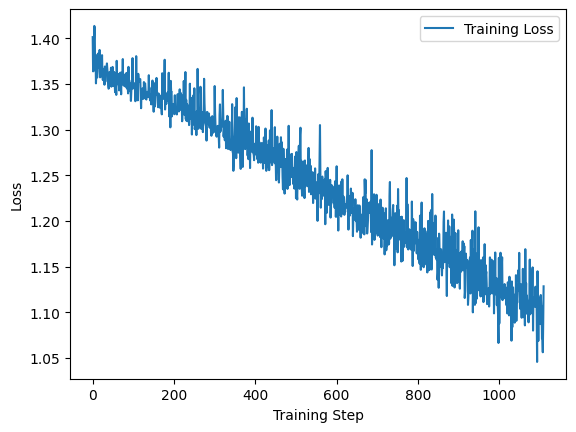

In [18]:
import matplotlib.pyplot as plt

# Plotting the training losses
plt.plot(train_losses, label='Training Loss')  # Plot training loss
plt.xlabel('Training Step')  # Label x-axis
plt.ylabel('Loss')  # Label y-axis
plt.legend()  # Show legend
plt.show()  # Display plot


### accuracy and prediction in validation set

In [19]:
# Check if CUDA is available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load validation graph and move it to the selected device
val_graph = torch.load('validate.pt')  # Load validation graph from file
val_graph = val_graph.to(device)  # Move validation graph to the selected device


In [20]:
def validate(model, link_predictor, x, edge_index, pos_val_edge, batch_size, max_steps=None):
    # Set the model and link predictor to evaluation mode
    model.eval()
    link_predictor.eval()

    # Initialize lists to store validation losses, predictions, and ground truth labels
    val_losses = []
    predictions = []
    ground_truth_labels = []

    # Determine the number of steps for validation
    num_steps = min(len(pos_val_edge), max_steps) if max_steps else len(pos_val_edge)

    # If there are no steps for validation, print a message and return empty lists
    if num_steps == 0:
        print("No steps for validation.")
        return val_losses, predictions, ground_truth_labels

    # Iterate over validation steps
    for step in tqdm(range(num_steps), leave=True):
        # Determine the edge index for this step
        edge_id = step % len(pos_val_edge)

        # No need to zero_grad or backpropagate during validation
        with torch.no_grad():
            # Run message passing on the initial node features to get updated embeddings
            node_emb = model(x, edge_index)

            # Positive edges
            pos_edge = pos_val_edge[edge_id].T
            pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])

            # Negative edges sampling (for validation, use all possible negative edges)
            neg_edge = negative_sampling(edge_index, num_nodes=x.shape[0], num_neg_samples=x.shape[0] - len(pos_val_edge), method='dense')
            neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])

            # Compute negative log likelihood loss on positive and negative edges
            loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()

            # Append loss to validation losses list
            val_losses.append(loss.item())

            # Store predictions and ground truth labels for evaluation
            predictions.extend(torch.sigmoid(pos_pred).cpu().numpy().flatten().tolist())
            ground_truth_labels.extend([1] * len(pos_pred))
            predictions.extend(torch.sigmoid(neg_pred).cpu().numpy().flatten().tolist())
            ground_truth_labels.extend([0] * len(neg_pred))

    return val_losses, predictions, ground_truth_labels


In [21]:
# Set the maximum number of validation steps
max_validation_steps = 50

# Perform validation with the specified parameters
val_losses, val_predictions, val_ground_truth = validate(
    model,  # The trained model
    link_predictor,  # The link predictor
    torch.tensor(val_graph.x).to(torch.float32).to(device),  # Validation node features on the selected device
    val_graph.edge_index,  # Validation edge index
    val_graph.pos_edge_label_index.T,  # Positive validation edge labels
    batch_size,  # Batch size for validation
    max_steps=max_validation_steps  # Maximum number of validation steps
)


C:\Users\reshm\AppData\Local\Temp\ipykernel_28888\3465878474.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_graph.x).to(torch.float32).to(device),  # Validation node features on the selected device
  0%|          | 0/50 [00:00<?, ?it/s]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


C:\Users\reshm\AppData\Local\Temp\ipykernel_28888\3727359135.py:30: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3679.)
  pos_edge = pos_val_edge[edge_id].T
  2%|▏         | 1/50 [00:01<01:25,  1.75s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  4%|▍         | 2/50 [00:03<01:21,  1.70s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  6%|▌         | 3/50 [00:05<01:20,  1.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


  8%|▊         | 4/50 [00:06<01:20,  1.75s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 10%|█         | 5/50 [00:08<01:17,  1.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 12%|█▏        | 6/50 [00:10<01:17,  1.76s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 14%|█▍        | 7/50 [00:12<01:14,  1.72s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 16%|█▌        | 8/50 [00:13<01:11,  1.71s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 18%|█▊        | 9/50 [00:15<01:07,  1.65s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 20%|██        | 10/50 [00:16<01:05,  1.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 22%|██▏       | 11/50 [00:18<01:02,  1.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 24%|██▍       | 12/50 [00:20<01:02,  1.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 26%|██▌       | 13/50 [00:21<01:00,  1.64s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 28%|██▊       | 14/50 [00:23<00:57,  1.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 30%|███       | 15/50 [00:24<00:55,  1.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 32%|███▏      | 16/50 [00:26<00:53,  1.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 34%|███▍      | 17/50 [00:28<00:52,  1.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 36%|███▌      | 18/50 [00:29<00:51,  1.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 38%|███▊      | 19/50 [00:31<00:48,  1.57s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 40%|████      | 20/50 [00:32<00:47,  1.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 42%|████▏     | 21/50 [00:34<00:45,  1.57s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 44%|████▍     | 22/50 [00:35<00:44,  1.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 46%|████▌     | 23/50 [00:37<00:42,  1.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 48%|████▊     | 24/50 [00:39<00:41,  1.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 50%|█████     | 25/50 [00:40<00:39,  1.57s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 52%|█████▏    | 26/50 [00:42<00:38,  1.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 54%|█████▍    | 27/50 [00:43<00:36,  1.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 56%|█████▌    | 28/50 [00:45<00:34,  1.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 58%|█████▊    | 29/50 [00:47<00:33,  1.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 60%|██████    | 30/50 [00:48<00:32,  1.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 62%|██████▏   | 31/50 [00:50<00:30,  1.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 64%|██████▍   | 32/50 [00:51<00:28,  1.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 66%|██████▌   | 33/50 [00:53<00:27,  1.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 68%|██████▊   | 34/50 [00:55<00:25,  1.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 70%|███████   | 35/50 [00:56<00:24,  1.60s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 72%|███████▏  | 36/50 [00:58<00:22,  1.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 74%|███████▍  | 37/50 [01:00<00:21,  1.63s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 76%|███████▌  | 38/50 [01:01<00:19,  1.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 78%|███████▊  | 39/50 [01:03<00:17,  1.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 80%|████████  | 40/50 [01:04<00:16,  1.61s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 82%|████████▏ | 41/50 [01:06<00:14,  1.57s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 84%|████████▍ | 42/50 [01:07<00:12,  1.57s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 86%|████████▌ | 43/50 [01:09<00:10,  1.55s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 88%|████████▊ | 44/50 [01:11<00:09,  1.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 90%|█████████ | 45/50 [01:12<00:07,  1.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 92%|█████████▏| 46/50 [01:14<00:06,  1.58s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 94%|█████████▍| 47/50 [01:15<00:04,  1.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 96%|█████████▌| 48/50 [01:17<00:03,  1.57s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


 98%|█████████▊| 49/50 [01:18<00:01,  1.59s/it]

Input Shape: torch.Size([10000, 1])
Output Shape: torch.Size([10000, 1024])


100%|██████████| 50/50 [01:20<00:00,  1.61s/it]


In [22]:
# Calculate accuracy using the ground truth labels and predicted probabilities
val_accuracy = accuracy_score(val_ground_truth, np.round(val_predictions))

# Output the mean validation loss
print(f"Validation Loss: {np.mean(val_losses)}")

# Output the validation accuracy
print(f"Validation Accuracy: {val_accuracy}")


Validation Loss: 1.3786751592159272
Validation Accuracy: 0.0033854077253218885


### using a small graph to show the prediction

In [23]:
# Load the complete graph from the specified file
graph = torch.load('AmazonNodeGraph.pt')

# Create a mask to select a subset of nodes
mask = np.zeros(graph.x.shape[0])  # Initialize mask with zeros
mask[10000:10500] = 1  # Set the mask to 1 for the selected node range
mask = torch.tensor(mask == 1)  # Convert mask to a PyTorch tensor

# Create a small graph by selecting nodes based on the mask
small_graph = Data(
    x=graph.x[mask],  # Node features for the selected nodes
    edge_index=utils.subgraph(mask, graph.edge_index)[0]  # Subgraph edge index for the selected nodes
)

# Adjust edge index to match the selected node range
small_graph.edge_index = small_graph.edge_index - 10000


FileNotFoundError: [Errno 2] No such file or directory: 'AmazonNodeGraph.pt'

In [ ]:
# Initialize dictionaries to store metadata and product data
metadata = {}
product_data = {}

# Open the file containing metadata
with open('../amazon-meta.txt', 'r', encoding="utf8") as file:
    # Skip the first two lines
    for _ in range(2):
        next(file)
    
    # Iterate through each line in the file
    for line in file:
        line = line.strip()  # Remove leading and trailing whitespace
        
        # If the line is not empty
        if line:
            try:
                # Split the line into key and value pairs
                key, value = map(str.strip, line.split(':', 1))
                product_data[key] = value  # Store key-value pairs in product_data dictionary
            except Exception:  # Handle cases where only value is present, no key
                key = ''
                value = ''
                pass
        else:  # An empty line indicates the end of one product's data
            if product_data:  # If product_data is not empty
                product_id = product_data.get('Id')  # Get the product ID
                if product_id:  # If product ID exists
                    metadata[product_id] = product_data  # Store product data in metadata dictionary
                product_data = {}  # Reset product_data dictionary for the next product
                         #Reset the current_product dictionary for the next product

In [ ]:
# Initialize PyVis network visualization
net = Network(height="750px", width="100%", bgcolor="#222222", font_color="white")

# Counter variable for tracking edges
k = 0

# Iterate through each edge in the small graph
for e in tqdm(small_graph.edge_index.T):
    k += 1  # Increment edge counter
    src = e[0].item()  # Source node
    dst = e[1].item()  # Destination node

    # Get predicted labels for the source and destination nodes
    src_predicted_label = val_predictions[src]
    dst_predicted_label = val_predictions[dst]

    # Extract metadata for the source and destination nodes
    src_metadata = metadata.get(str(src), {})
    dst_metadata = metadata.get(str(dst), {})

    # Print metadata for the first edge (for debugging purposes)
    if k == 1:
        print(src_metadata['group'])
        print(dst_metadata)

    # Construct node titles with metadata
    src_title = f"Node {src}\nMetadata:\n{src_metadata.get('group', 'N/A')}"
    dst_title = f"Node {dst}\nMetadata:\n{dst_metadata.get('group', 'N/A')}"

    # Add nodes to the visualization with labels and titles
    net.add_node(src, label=src_title, title=src_title)
    net.add_node(dst, label=dst_title, title=dst_title)

    # Add edges between source and destination nodes
    net.add_edge(src, dst, value=0.1)

# Display the PyVis visualization
net.show("PredictionsGraphSample", notebook=False)


  0%|          | 0/470 [00:00<?, ?it/s]

Book
{'Id': '3', 'ASIN': '0486287785', 'title': 'World War II Allied Fighter Planes Trading Cards', 'group': 'Book', 'salesrank': '1270652', 'similar': '0', 'categories': '1', 'reviews': 'total: 1  downloaded: 1  avg rating: 5', '2003-7-10  cutomer': 'A3IDGASRQAW8B2  rating: 5  votes:   2  helpful:   2'}
/content/drive/MyDrive/Graph /smaller_graph_with_predictions_and_metadata.html
